In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Read in words

words = open(file='../data/names.txt',mode='r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
len(words)

32033

In [7]:
chars   = sorted(set(''.join(words)))
stoi    = {s:i+1 for i,s in enumerate(chars)} # string to integer
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()} # integer to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
# Building the dataset
block_size = 3

X, Y = [], [] # x is input, y is label (i.e. pred)
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
    
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y) 

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


We are going to create a neural net similar to the one documented in Bengio et al. 2003 MLP language model paper[https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf]


![neural](./img/neural-net.png)

Below we have created 32 examples with 3 inputs (i.e. 3 chars inputted to each example) into the model 

In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Lets create embeddings in a two dimensional space. We have 27 characters, each of which will have a 2d embedding

In [10]:
C = torch.randn((27,2)) # 27 characters each which have 2 dimensional space
C

tensor([[-1.0391, -1.7747],
        [ 1.4753,  1.7935],
        [ 0.2033, -0.7639],
        [-2.6745, -0.4900],
        [-0.0354,  1.0657],
        [-0.2403,  1.8524],
        [-0.2633, -0.7751],
        [ 1.7207, -0.3457],
        [-0.2487, -1.9388],
        [ 0.9401,  0.5458],
        [ 0.9757, -0.6364],
        [ 0.7465,  0.5840],
        [ 0.2195,  0.5667],
        [ 2.1223, -0.4602],
        [ 0.0972,  0.4985],
        [ 1.3403,  0.4971],
        [-1.3763, -0.7109],
        [-0.7359,  0.2572],
        [ 0.5887,  0.1764],
        [-0.1795, -0.5231],
        [-0.8104,  0.1972],
        [-0.3610,  1.7343],
        [-0.9840, -1.2360],
        [-0.5217,  0.5058],
        [ 1.4264,  0.4219],
        [ 0.0908, -0.3331],
        [-1.1184, -0.3436]])

The below gets the embedding value for 5th index

In [11]:
C[5]

tensor([-0.2403,  1.8524])

We can also feed in multidimension tensors. In our case, we can feed in C[X] where X = torch.Size([32, 3]) 32 examples with 3 inputs for each

Creates our embedding

In [12]:
# embed all our values
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Now lets create layer 1

![layer](./img/neural-net-layer-1.png)

looking at the image above and the fact that torch.Size([32, 3, 2]), we require 6 weights as 3*2 (i.e. 3 inputs with in 2 dimensional embedding)

Number of neurons is a variable which we can decide on, we choose 100 

For biases, we'll also need 100 to match the neurons

In [13]:
# Create weights for next layer 
W1 = torch.rand((6, 100))
b1 = torch.rand(100)

Next we want to muiltiply our weights and add bias but we cant as emb is a torch.Size([32, 3, 2])

we can use pytorch view to do this. We concatenate across dimension 1 which combines the 3 different inputs (i.e. blocks of chars)

In [14]:
# -1 just lets pytorch figure out the value required
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
h

tensor([[-1.0000, -0.9979, -0.9994,  ..., -0.9936, -0.9993, -0.9964],
        [-0.9900, -0.3635, -0.5894,  ..., -0.8707, -0.6979, -0.3013],
        [-0.1925,  0.9473,  0.9948,  ..., -0.3458,  0.9646,  0.9736],
        ...,
        [-0.4843, -0.9553, -0.9683,  ..., -0.6079, -0.8400, -0.9725],
        [-0.9628, -0.4180, -0.1448,  ..., -0.4487, -0.7086, -0.1391],
        [ 0.8713,  0.9976,  0.9979,  ...,  0.7821,  0.9879,  0.9978]])

In [15]:
h.shape

torch.Size([32, 100])

Now let's create the final layer
![layer](./img/neural-net-layer-2.png)

In [16]:
W2 = torch.randn(100, 27) # input is 100 neurons, and output is 27 as 27 possible characters
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([32, 27])

Exponentiate logits and normalize

In [19]:
counts = logits.exp() # make sure all values are positive and amplify differences

In [20]:
prob = counts / counts.sum(1, keepdims=True) # normalise to get prob distribution, sum along second dimension

In [21]:
prob.shape

torch.Size([32, 27])

Now we need to introduce our prediction sequence Y

We want to identify the probability from each row of prob, we want to pluck out the probability assigned to the correct character

In [22]:
prob[torch.arange(32), Y] # for each row, pick out the probability of the correct Y value

tensor([6.9537e-09, 4.5287e-09, 4.5303e-06, 6.2120e-09, 1.7511e-19, 6.2322e-12,
        1.9591e-09, 1.8782e-05, 1.9580e-03, 3.0505e-01, 1.5112e-06, 1.5845e-15,
        3.7698e-13, 1.4419e-09, 3.8092e-10, 6.3772e-20, 8.5225e-21, 2.3056e-04,
        5.2082e-09, 9.0871e-11, 3.7657e-11, 2.6614e-07, 9.6880e-04, 4.4848e-09,
        1.0450e-19, 3.8982e-04, 1.5227e-11, 9.8626e-03, 5.8504e-10, 2.5537e-11,
        8.2904e-07, 2.7158e-15])

In [23]:
"""
Now let's get the negative log likelihood loss
"""

loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(21.1012)

# ------------ now made respectable :) ---------------

# Broken down into training, dev, and test set

In [75]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [77]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [83]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [88]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [89]:
for p in parameters:
    p.requires_grad = True

Another way to calculate loss is to use pytorch cross entropy

In [90]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [91]:
lri, lossi, stepi = [], [], [] # learning rates used and losses

# Forward pass
for i in range(30000):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    emb = C[Xtr[ix]] # index into X to only grab ix rows (32, 3, 2)
    # -1 just lets pytorch figure out the value required
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

2.0562691688537598


plot the learning rates and loss exponent to see what the optimal learning rate is. below we can deduce .1 us a good learning rate as exponent pf -1 is .1

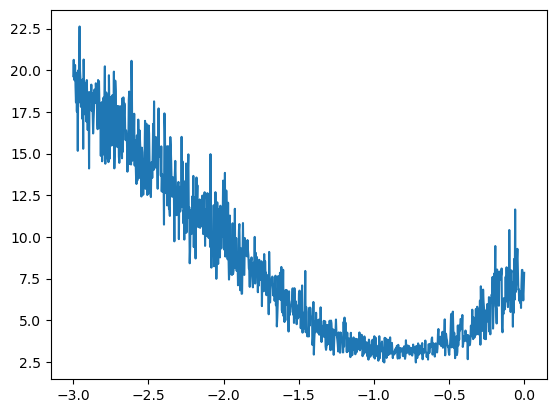

In [53]:

plt.plot(lri, lossi)

Get loss for all of Xdev and all of Ydev, above we are calculating loss of minibatches

In [92]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.5230, grad_fn=<NllLossBackward0>)

Learning decay - at late stages of training, we decrease the learning rate  lrto identify the optimal point

In [72]:
lri, lossi = [], [] # learning rates used and losses

# Forward pass
for i in range(10000):

    # minibatch construct 
    ix = torch.randint(0, X.shape[0], (32, ))

    emb = C[X[ix]] # index into X to only grab ix rows (32, 3, 2)
    # -1 just lets pytorch figure out the value required
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
# print(loss.item())

In [73]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2419, grad_fn=<NllLossBackward0>)

Now lets split our data into training, dev, and test 80%, 10%, 10% respective